In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                

In [3]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         horizontal_flip = True,
                                         zoom_range = 0.2)

val_datagen = image.ImageDataGenerator(rescale=1./255)

In [4]:
training_data = train_datagen.flow_from_directory('Train',
                                                  target_size=(224,224),
                                                  class_mode='binary',
                                                  batch_size=32)

val_data = val_datagen.flow_from_directory('Val',
                                           target_size=(224,224),
                                           class_mode='binary',
                                           batch_size=32)

Found 282 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [5]:
training_data.class_indices

{'COVID': 0, 'NORMAL': 1}

In [6]:
e = 20
hist = model.fit(training_data,
                    steps_per_epoch=8,
                    epochs = e,
                    validation_data = val_data,
                    validation_steps = 2)
model.save('../models/covid.h5')

Epoch 1/20


8/8 [==============================] - 27s 3s/step - loss: 2.2044 - accuracy: 0.5400 - val_loss: 0.6911 - val_accuracy: 0.7344
Epoch 2/20
8/8 [==============================] - 24s 3s/step - loss: 0.6933 - accuracy: 0.5156 - val_loss: 0.6906 - val_accuracy: 0.9219
Epoch 3/20
8/8 [==============================] - 23s 3s/step - loss: 0.6718 - accuracy: 0.6160 - val_loss: 0.6423 - val_accuracy: 0.8750
Epoch 4/20
8/8 [==============================] - 23s 3s/step - loss: 0.5027 - accuracy: 0.7840 - val_loss: 0.4079 - val_accuracy: 0.8750
Epoch 5/20
8/8 [==============================] - 22s 3s/step - loss: 0.4304 - accuracy: 0.7960 - val_loss: 0.3310 - val_accuracy: 0.9062
Epoch 6/20
8/8 [==============================] - 22s 3s/step - loss: 0.3354 - accuracy: 0.8720 - val_loss: 0.3205 - val_accuracy: 0.8594
Epoch 7/20
8/8 [==============================] - 22s 3s/step - loss: 0.3291 - accuracy: 0.8520 - val_loss: 0.2780 - val_accuracy: 0.9219
Epoch 8/20
8/8 [================

C:\Users\zakza\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


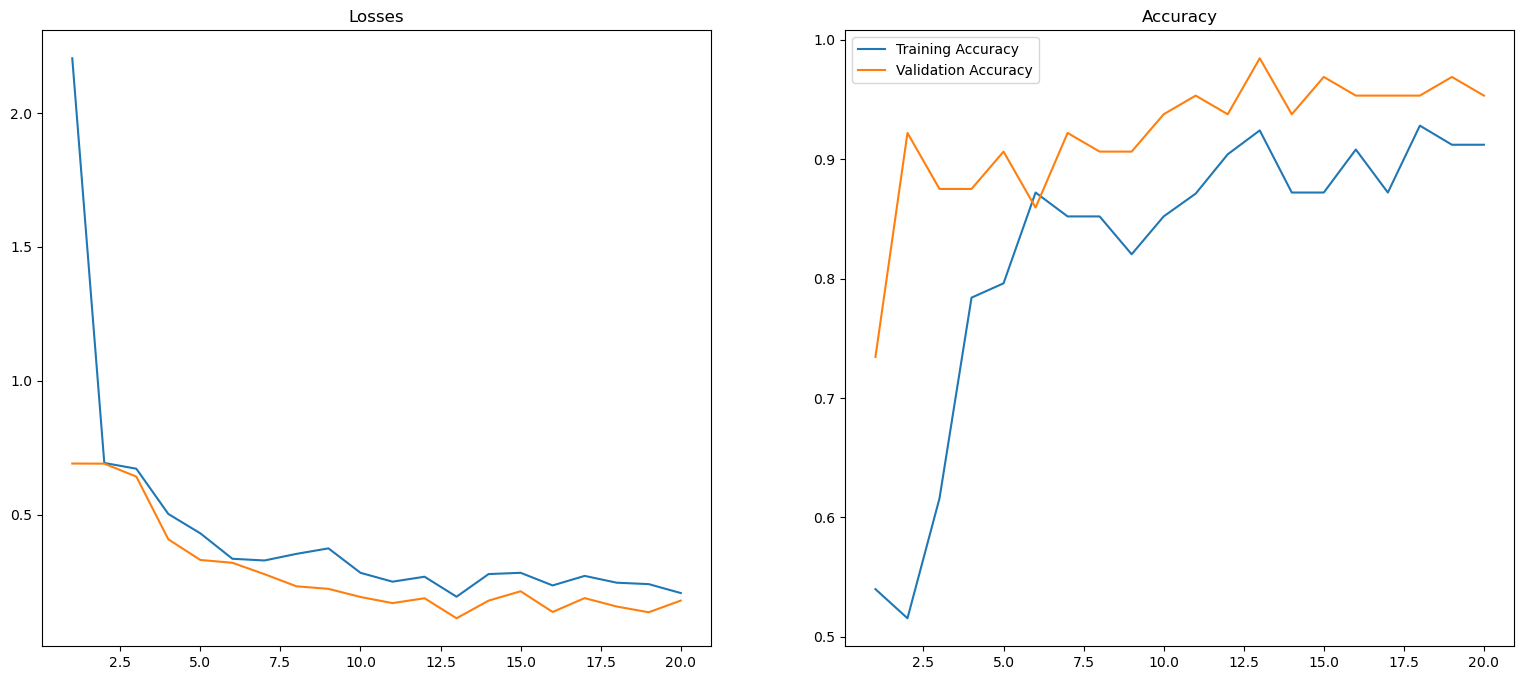

In [7]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1,e+1)

plt.figure(figsize=(19,8))
plt.subplot(121)
plt.plot(epochs,train_loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Losses')

plt.subplot(122)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.title('Accuracy')

plt.legend()

In [9]:
model.evaluate_generator(training_data)

C:\Users\zakza\AppData\Local\Temp\ipykernel_20180\4125820930.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(training_data)


[0.12822125852108002, 0.9503546357154846]

In [10]:
model.evaluate_generator(val_data)

C:\Users\zakza\AppData\Local\Temp\ipykernel_20180\3807241483.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_data)


[0.14771662652492523, 0.9624999761581421]

### Testing

1/1 [==============================] - 0s 28ms/step


<Axes: >

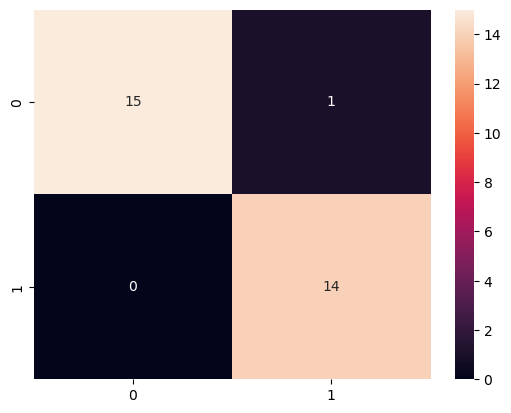

In [12]:
import cv2
import os
import seaborn as sns
from tensorflow.keras.models import load_model

TP = 0
TN = 0
FP = 0
FN = 0

model = load_model('../models/covid.h5')

covid_images = os.listdir('Test/COVID')
normal_images = os.listdir('Test/NORMAL')

for i in covid_images:
    img = cv2.imread('Test/COVID/'+i)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    img = img/255.0
    pred = model.predict(img)
    if pred<0.5:
        TP+=1
    else:
        FN+=1

for i in normal_images:
    img = cv2.imread('Test/NORMAL/'+i)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    img = img/255.0
    pred = model.predict(img)
    if pred>0.5:
        TN+=1
    else:
        FP+=1
  
sns.heatmap([[TP,FP],[FN,TN]],annot=True)